In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn import metrics
import xgboost as xgb

In [5]:
#Import training and test data
df = pd.read_csv('build/training_data.csv')
lbl = df['label']
df = df.drop(columns='label')

Xtrain,Xtest, ytrain, ytest = train_test_split(df, lbl, test_size = 0.3, random_state = 555)

In [ ]:
#Implementing training function with stratifiesKFold
def trainModel(X,y,k = 5):
    skf = StratifiedKFold(n_splits=k, random_state=555, shuffle=True)
    model = []
    for _, (train_index, test_index) in zip(tqdm(range(k)), skf.split(X, y)):
        bdt = xgb.XGBClassifier(tree_method='hist', random_state=555, objective='binary:logistic'
                              , early_stopping_rounds=10, eval_metric=["logloss"])
        
        bdt.fit(X.to_numpy()[train_index], y.to_numpy()[train_index],
                eval_set=[(X.to_numpy()[test_index], y.to_numpy()[test_index])]);
        model.append(bdt)
    return model

model = trainModel(Xtrain,ytrain, 5)

  0%|                                                     | 0/5 [00:00<?, ?it/s]

[0]	validation_0-logloss:0.49654
[1]	validation_0-logloss:0.38154
[2]	validation_0-logloss:0.30782
[3]	validation_0-logloss:0.25640
[4]	validation_0-logloss:0.22069
[5]	validation_0-logloss:0.19411
[6]	validation_0-logloss:0.17329
[7]	validation_0-logloss:0.15717
[8]	validation_0-logloss:0.14562
[9]	validation_0-logloss:0.13742
[10]	validation_0-logloss:0.13080
[11]	validation_0-logloss:0.12573
[12]	validation_0-logloss:0.12036
[13]	validation_0-logloss:0.11680
[14]	validation_0-logloss:0.11419
[15]	validation_0-logloss:0.11095
[16]	validation_0-logloss:0.10901
[17]	validation_0-logloss:0.10816
[18]	validation_0-logloss:0.10667
[19]	validation_0-logloss:0.10453
[20]	validation_0-logloss:0.10409
[21]	validation_0-logloss:0.10362
[22]	validation_0-logloss:0.10274
[23]	validation_0-logloss:0.10209
[24]	validation_0-logloss:0.10222
[25]	validation_0-logloss:0.10174
[26]	validation_0-logloss:0.10022
[27]	validation_0-logloss:0.09965
[28]	validation_0-logloss:0.09907
[29]	validation_0-loglos

 20%|█████████                                    | 1/5 [00:01<00:06,  1.72s/it]

[0]	validation_0-logloss:0.49915
[1]	validation_0-logloss:0.38534
[2]	validation_0-logloss:0.31045
[3]	validation_0-logloss:0.26012
[4]	validation_0-logloss:0.22254
[5]	validation_0-logloss:0.19538
[6]	validation_0-logloss:0.17676
[7]	validation_0-logloss:0.16077
[8]	validation_0-logloss:0.14873
[9]	validation_0-logloss:0.13935
[10]	validation_0-logloss:0.13294
[11]	validation_0-logloss:0.12750
[12]	validation_0-logloss:0.12333
[13]	validation_0-logloss:0.11953
[14]	validation_0-logloss:0.11552
[15]	validation_0-logloss:0.11354
[16]	validation_0-logloss:0.11098
[17]	validation_0-logloss:0.10891
[18]	validation_0-logloss:0.10705
[19]	validation_0-logloss:0.10611
[20]	validation_0-logloss:0.10496
[21]	validation_0-logloss:0.10406
[22]	validation_0-logloss:0.10363
[23]	validation_0-logloss:0.10248


In [8]:
#Implementing prediction
def predict(model, X):
    res = []
    for m in model:
        res.append(m.predict_proba(X)[:,1])
    return np.mean(res, axis = 0)

ypred = predict(model, Xtest.to_numpy())
ypred

array([2.2522206e-04, 9.9980611e-01, 3.3993616e-03, ..., 9.9649560e-01,
       6.3329506e-01, 9.9985284e-01], dtype=float32)

0.9955077181593477


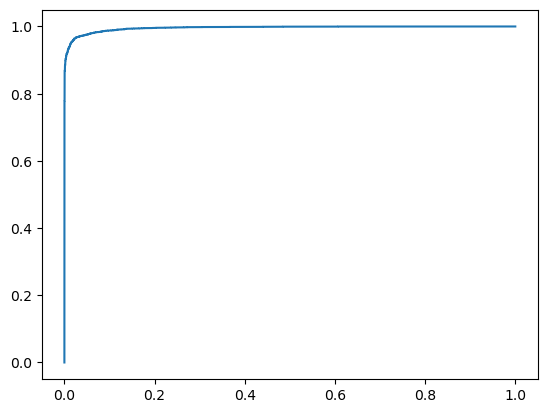

In [9]:
#Calc ROC,AUC curve
fpr, tpr, thresholds = metrics.roc_curve(ytest, ypred)
plt.plot(fpr,tpr);
AUC = metrics.roc_auc_score(ytest, ypred)
print(AUC)

In [10]:
#save ROC,AUC curve to disk
file = open('build/BdtRoc.txt', 'w')
file.write('#fpr tpr\n')
for f, t in zip(fpr, tpr):
    file.write(f'{f} {t}\n')
file.write(f'-1 {AUC}')
file.close()

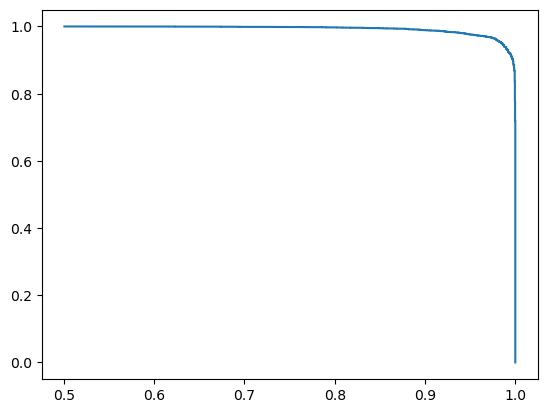

In [11]:
#Calc Precision Recall curve
prec, rec, thresh = metrics.precision_recall_curve(ytest, ypred)

plt.plot(prec, rec)

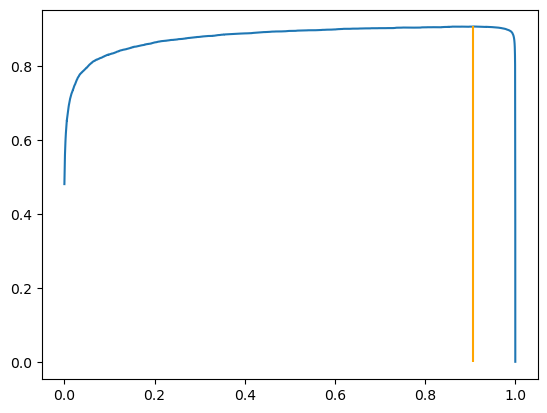

In [12]:
#Find Threshold with fbeta score and classify test data
def fbeta(p, r, beta = 0.1):
    return (1+beta**2)*(p*r)/(beta*p+r)

fb = fbeta(prec, rec)[:-1]
argTr = np.argmax(fb)
plt.plot(thresh, fb)
plt.vlines(thresh[argTr], 0, fb[argTr], color = 'orange', label = 'peak')

threshold = thresh[argTr]
ycls = ypred > threshold
ycls = [1 if i else 0 for i in ycls]

In [13]:
#save ROC,AUC and fbeta curve to disk
file = open('build/BdtPRC.txt', 'w')
file.write('#Precision Recal\n')
for f, t,b in zip(prec[:-1], rec[:-1], fb):
    file.write(f'{f} {t} {b}\n')
file.close()

In [14]:
#save predictions
file = open('build/BdtClassified.txt', 'w')
file.write('#label\n')
for f in ycls:
    file.write(f'{f}\n')
file.close()